In [1]:
%pylab inline

from scipy.optimize import root_scalar
from scipy.integrate import trapezoid

Populating the interactive namespace from numpy and matplotlib


In formalism.ipynb we investigated the basic outline of the paper. In this notebook we will extend the method a little bit, as noted in the conclusion. One of the ways proposed to improve this measurement of $\pi$ is to use more than a single half period of the probability function to estimate $\pi$. In this notebook I'll introduce some code that uses two half-periods per qubit to estimate $\pi$.

In [2]:
class Qubit:
    def __init__(self, seed, alpha, beta, phi0, c):
        self.alpha = alpha
        self.beta = beta
        self.phi0 = phi0
        self.c = c
        
        self.prob = lambda t: alpha / 2 * (1 - np.cos(c * t + phi0)) + beta
        
        self.rng = np.random.default_rng(seed)
        
    def measure(self, t, n=1):
        # The n parameter allows us to run multiple measurements for the same time step
        # with one function call. This speeds up the computation a bit.
        v = self.rng.random(size=n)
        p = self.prob(t)
        
        # "less than" ensures the probability actually works as intended
        return np.where(v < p, 1, 0)

Must of this following code remains the same as before, so I've kept it the same up to the point where things change, at which point I'll introduce some commentary. The first obvious change is that we're going to need to get to at least $3\pi$ in time steps, so I'll just call it an even 10.

In [3]:
time_steps = np.arange(0, 10, 0.1)

q = {}
f = {}
f1 = {}
f1_interp = {}
alpha_hat = {}
beta_hat = {}

for i in range(5):
    seed = 6 * i + 7 * (i % 3)
    print(f"Adding qubit with seed {seed}")
    q[i] = Qubit(seed, 1, 0, 0, 1)
    
    
    vals = []
    n_measure = 8192
    for t in time_steps:
        m = q[i].measure(t, n_measure)
        frac = np.sum(m) / len(m)
        vals.append(frac)

    f[i] = np.asarray(vals)

    beta_hat[i] = np.min(f[i])
    alpha_hat[i] = np.max(f[i]) - beta_hat[i]

    f1[i] = (f[i] - beta_hat[i]) / alpha_hat[i]
    f1_interp[i] = lambda x: np.interp(x, time_steps, f1[i])

    print(alpha_hat[i], beta_hat[i])

Adding qubit with seed 0
0.9998779296875 0.0
Adding qubit with seed 13
1.0 0.0
Adding qubit with seed 26
0.999755859375 0.0
Adding qubit with seed 18
0.999755859375 0.0
Adding qubit with seed 31
0.9998779296875 0.0


As before, Nwe want to find where $\tilde{f_1} \approx 0.5$, except now instead of being just close to $t_1 = 1.5$ and $t_2 = 4.5$ we also seek where it's close to $t_3=8$. As before I define an $f_2$ interpolation that is simply $f_1 - 0.5$ for root finding purposes, since the root finder looks for 0's.

In [4]:
t1 = {}
t2 = {}
t3 = {}

for i in range(len(q)):
    f2 = lambda x: np.interp(x, time_steps, f1[i]) - 0.5

    t1[i] = root_scalar(f2, x0=1.5, x1=2).root
    t2[i] = root_scalar(f2, x0=4.5, x1=5).root
    t3[i] = root_scalar(f2, x0=7.6, x1=8).root

    print(t1[i], t2[i], t3[i])

1.5726506024096387 4.690212264150944 7.861341463414635
1.5686746987951807 4.717747440273038 7.857105943152455
1.5613577023498695 4.719298245614035 7.855022831050229
1.5615658362989324 4.697797356828194 7.861419068736143
1.5850332594235035 4.725844155844156 7.86701388888889


Next steps are the same as before, where we estimate and refine $\hat{\alpha}$ and $\hat{\beta}$, except this time we no longer have to vaguely estimate $t_{minval}$ from $t_1$ and $t_2$, this time we can know it must be between $t_2$ and $t_3$.

In [5]:
delta = 0.1
t1_hat = {}
t2_hat = {}
t3_hat = {}

for i in range(len(q)):
    t_maxval = (t1[i] + t2[i]) / 2
    t_minval = (t2[i] + t3[i]) / 2

    # Indices of time steps that satisfy this condition
    tmax = np.where(np.abs((time_steps - t_maxval)) < delta)[0]
    tmin = np.where(np.abs((time_steps - t_minval)) < delta)[0]

    beta_hat[i] = np.mean(f[i][tmin])
    alpha_hat[i] = np.mean(f[i][tmax]) - beta_hat[i]

    f1[i] = (f[i] - beta_hat[i]) / alpha_hat[i]
    f1_interp[i] = lambda x: np.interp(x, time_steps, f1[i])

    print(alpha_hat[i], beta_hat[i])
    
    # Indices of time steps that fulfill the above condition.
    t1_idx = np.where(np.abs((time_steps - t1[i])) < 0.5)[0]
    coeff_1 = np.polyfit(time_steps[t1_idx], f1[i][t1_idx], 1)

    # Once again subtracting 0.5 to find where the function = 0.5 not 0.
    fit_1 = lambda x: coeff_1[0] * x + coeff_1[1] - 0.5
    t1_hat[i] = root_scalar(fit_1, x0=1.5, x1=2).root

    # Indices of time steps that fulfill the above condition.
    t2_idx = np.where(np.abs((time_steps - t2[i])) < 0.5)[0]
    coeff_2 = np.polyfit(time_steps[t2_idx], f1[i][t2_idx], 1)

    # Once again subtracting 0.5 to find where the function = 0.5 not 0.
    fit_2 = lambda x: coeff_2[0] * x + coeff_2[1] - 0.5
    t2_hat[i] = root_scalar(fit_2, x0=4.5, x1=5).root
    
    # Indices of time steps that fulfill the above condition.
    t3_idx = np.where(np.abs((time_steps - t3[i])) < 0.5)[0]
    coeff_3 = np.polyfit(time_steps[t3_idx], f1[i][t3_idx], 1)

    # Once again subtracting 0.5 to find where the function = 0.5 not 0.
    fit_3 = lambda x: coeff_3[0] * x + coeff_3[1] - 0.5
    t3_hat[i] = root_scalar(fit_3, x0=7.5, x1=8).root


    print("New times", t1_hat[i], t2_hat[i], t3_hat[i])

0.99835205078125 0.0009765625
New times 1.5652957882327725 4.703451892282013 7.856444134843776
0.9986572265625 0.000732421875
New times 1.568840579710145 4.719675755895009 7.856578138816861
0.9981689453125 0.00128173828125
New times 1.5735023893941735 4.7173225878665805 7.854977183076802
0.998046875 0.0010986328125
New times 1.5690623798169379 4.716117272225964 7.857156086493491
0.99835205078125 0.00079345703125
New times 1.5764946576191274 4.721724415127796 7.858347365255955


Finaly we estimate the integral between $t_1$ and $t_2$ using the trapezoidal rule, which then gives us an estimate of $\pi$ via $\pi \approx \frac{t_2 - t_1}{I}$. This is the same as before, of course. However we must now include an additional step, and estimate the integral between $t_2$ and $t_3$ in order to get a second estimate from that time period. 

In [6]:
pi_guess = {}
cs = {}
for i in range(len(q)):
    f_hat = lambda x: np.interp(x, time_steps, f[i])

    # Adding the t1 and t2 to the measured timesteps for integration purposes.
    t_idx = np.where((time_steps >= t1[i]) & (time_steps <= t2[i]))[0]
    t_integ = time_steps[t_idx]
    t_integ = np.insert(t_integ, 0, t1_hat[i])
    t_integ = np.append(t_integ, t2_hat[i])

    # Doing the same for the probability measured values
    y_integ = f[i][t_idx]
    y_integ = np.insert(y_integ, 0, f_hat(t1_hat[i]))
    y_integ = np.append(y_integ, f_hat(t2_hat[i]))

    # Trapezoidal rule on the given points
    I1 = np.trapz(y_integ - 0.5, t_integ)
    
    # Adding the t2 and t3 to the measured timesteps for integration purposes.
    t_idx = np.where((time_steps >= t2[i]) & (time_steps <= t3[i]))[0]
    t_integ = time_steps[t_idx]
    t_integ = np.insert(t_integ, 0, t2_hat[i])
    t_integ = np.append(t_integ, t3_hat[i])

    # Doing the same for the probability measured values
    y_integ = f[i][t_idx]
    y_integ = np.insert(y_integ, 0, f_hat(t2_hat[i]))
    y_integ = np.append(y_integ, f_hat(t3_hat[i]))

    # Trapezoidal rule on the given points
    # We expect this one to be negative, so to estimate pi we will invert it to positve.
    I2 = -np.trapz(y_integ - 0.5, t_integ)
    
    # Estimating c as the average of the other two cs
    c = 1 / (2 * I1) + 1 / (2 * I2)
    cs[i] = c
    

    # And the final guess!
    pi_guess[i] = (t3_hat[i] - t2_hat[i]) * (c/2) + (t2_hat[i] - t1_hat[i]) * (c/2)

In [7]:
pi_init = np.nanmean(list(pi_guess.values()))

pi_init, 100 * (np.pi - pi_init) / np.pi

(3.1468160229369255, -0.1662650102381619)

Extending the method in this way does not improve accuracy a lot, however, it does make the method more robust to changes in $P(t)$, which you can prove for yourself by modifying constants.

In [8]:
def prob_func(t, alpha, beta, phi0, c):
    return alpha / 2 * (1 - np.cos(c * t + phi0)) + beta


def plot_qubits(args):
    fig, ax = plt.subplots(5, figsize=(10, 35))

    q = args[0]
    f = args[1]
    alpha_hat = args[2]
    beta_hat = args[3]
    c = args[4]

    for i in range(len(c)):
        ax[i].set_title(f"Qubit {i + 1}")
        ax[i].set_ylim(-0.05, 1.05)
        ax[i].plot(time_steps, f[i], ".")

        # Plot the fitted probabilty function
        ax[i].plot(time_steps, prob_func(time_steps, alpha_hat[i], beta_hat[i], 0, c[i]))
        
        text_str = "\n".join(["Estimated values:",
                              f"alpha = {alpha_hat[i]:.3f}", f"beta = {beta_hat[i]:.3f}", 
                              f"c = {c[i]:.3f}"])
        ax[i].text(0, 0.82, text_str, fontsize=16)
        
        # Plot the true probability function
        ax[i].plot(time_steps, prob_func(time_steps, q[i].alpha, q[i].beta, 0, q[i].c))
        
        text_str = "\n".join(["True values:",
                              f"alpha = {q[i].alpha:.3f}", f"beta = {q[i].beta:.3f}", 
                              f"c = {q[i].c:.3f}"])
        ax[i].text(5, 0.82, text_str, fontsize=16)
       

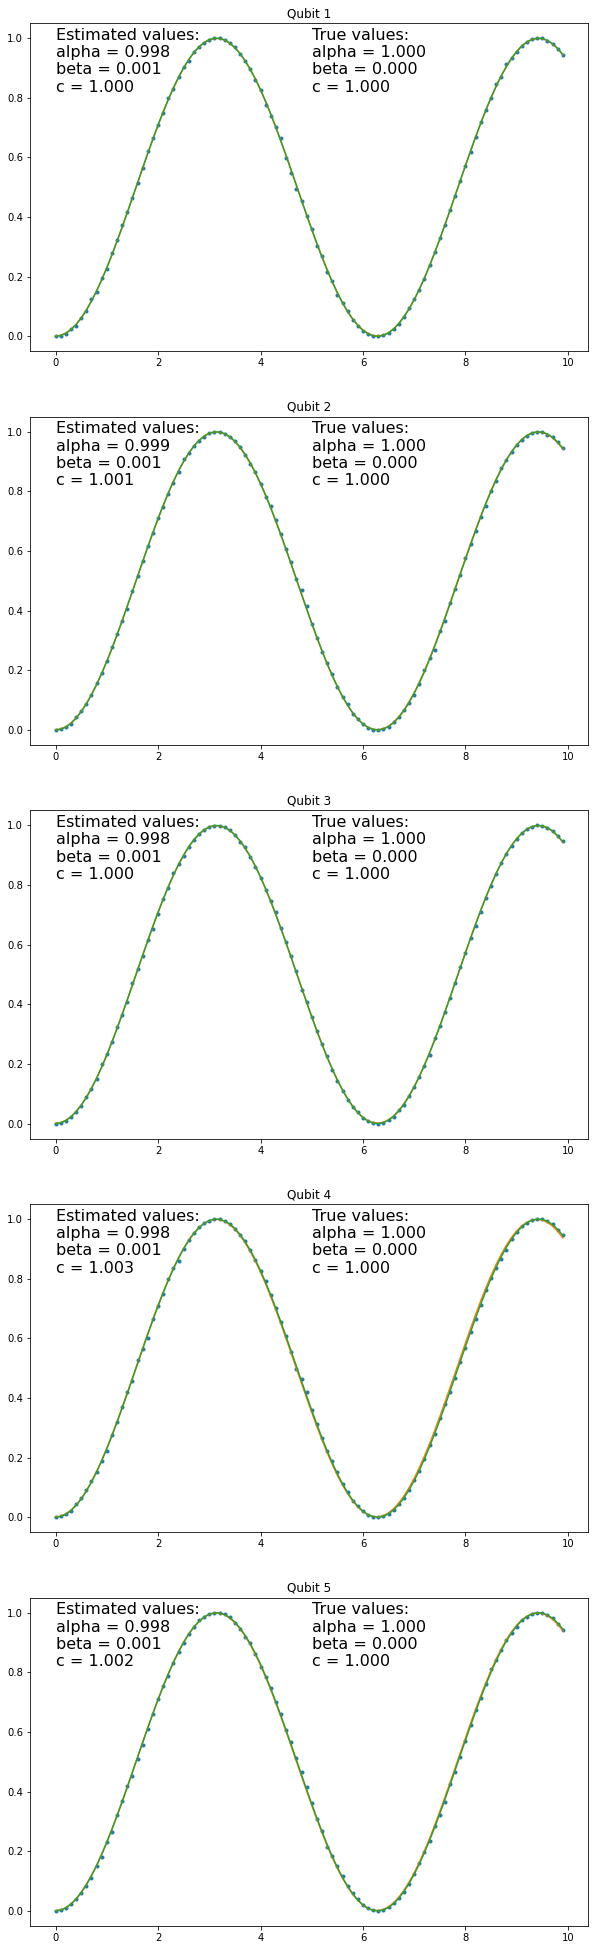

In [9]:
plot_qubits((q, f, alpha_hat, beta_hat, cs))

In [10]:
def run_simulation(n_qubits, n_measure=8192, alpha_range=None, beta_range=None, phi_range=None, 
                   c_range=None, verbose=True, return_coeffs=False):
    q = {}
    
    # Storing these for plotting purposes.
    if return_coeffs:
        fs = {}
        a = {}
        b = {}
        cs = {}
    
    pi_guess = {}
    time_steps = np.arange(0, 10, 0.1)
    
    rng = np.random.default_rng(91701)

    for i in range(n_qubits):
        seed = 6 * i + 7 * (i % 3)
        alpha = 1
        beta = 0
        c = 1
        phi_0 = 0
        
        if alpha_range is not None:
            if len(alpha_range) == 1: alpha = alpha_range[0]
            else:
                alpha = rng.random() * (alpha_range[-1] - alpha_range[0]) + alpha_range[0]
                if alpha < 0: alpha = 0
            
        if beta_range is not None:
            beta = rng.random() * (beta_range[-1] - beta_range[0]) + beta_range[0]
            if beta > 1 - alpha: beta = 1 - alpha # Normalization procedure
            if beta < 0: beta = 0
            
        if phi_range is not None:
            if len(phi_range) == 1: phi_0 = phi_range[0]
            phi_0 = rng.random() * (phi_range[-1] - phi_range[0]) + phi_range[0]
            
        if c_range is not None:
            if len(c_range) == 1: c = c_range[0]
            c = rng.random() * (c_range[-1] - c_range[0]) + c_range[0]

        
        if verbose: print(f"Adding qubit with seed {seed}, alpha {alpha}, beta {beta}, phi_0 {phi_0}, c {c}")
        q[i] = Qubit(seed, alpha, beta, phi_0, c)

        vals = []
        for t in time_steps:
            m = q[i].measure(t, n_measure)
            frac = np.sum(m) / len(m)
            vals.append(frac)

        f = np.asarray(vals)  

        beta_hat = np.min(f)
        alpha_hat = np.max(f) - beta_hat

        f1 = (f - beta_hat) / alpha_hat
        f1_interp = lambda x: np.interp(x, time_steps, f1)

        f2 = lambda x: np.interp(x, time_steps, f1) - 0.5

        t1 = root_scalar(f2, x0=1.5, x1=2).root
        t2 = root_scalar(f2, x0=4.5, x1=5).root
        t3 = root_scalar(f2, x0=7.6, x1=8).root

        t_maxval = (t1 + t2) / 2
        t_minval = (t2 + t3) / 2

        # Indices of time steps that satisfy this condition
        tmax = np.where(np.abs((time_steps - t_maxval)) < delta)[0]
        tmin = np.where(np.abs((time_steps - t_minval)) < delta)[0]

        beta_hat = np.mean(f[tmin])
        alpha_hat = np.mean(f[tmax]) - beta_hat

        f1 = (f - beta_hat) / alpha_hat
        f1_interp = lambda x: np.interp(x, time_steps, f1)

        # Indices of time steps that fulfill the above condition.
        t1_idx = np.where(np.abs((time_steps - t1)) < 0.5)[0]
        coeff_1 = np.polyfit(time_steps[t1_idx], f1[t1_idx], 1)

        # Once again subtracting 0.5 to find where the function = 0.5 not 0.
        fit_1 = lambda x: coeff_1[0] * x + coeff_1[1] - 0.5
        t1_hat = root_scalar(fit_1, x0=1.5, x1=2).root

        # Indices of time steps that fulfill the above condition.
        t2_idx = np.where(np.abs((time_steps - t2)) < 0.5)[0]
        coeff_2 = np.polyfit(time_steps[t2_idx], f1[t2_idx], 1)

        # Once again subtracting 0.5 to find where the function = 0.5 not 0.
        fit_2 = lambda x: coeff_2[0] * x + coeff_2[1] - 0.5
        t2_hat = root_scalar(fit_2, x0=1.5, x1=2).root
        
        # Indices of time steps that fulfill the above condition.
        t3_idx = np.where(np.abs((time_steps - t3)) < 0.5)[0]
        coeff_3 = np.polyfit(time_steps[t3_idx], f1[t3_idx], 1)

        # Once again subtracting 0.5 to find where the function = 0.5 not 0.
        fit_3 = lambda x: coeff_3[0] * x + coeff_3[1] - 0.5
        t3_hat = root_scalar(fit_3, x0=7.5, x1=8).root

        f_hat = lambda x: np.interp(x, time_steps, f)

        # Adding the t1 and t2 to the measured timesteps for integration purposes.
        t_idx = np.where((time_steps >= t1_hat) & (time_steps <= t2_hat))[0]
        t_integ = time_steps[t_idx]
        t_integ = np.insert(t_integ, 0, t1_hat)
        t_integ = np.append(t_integ, t2_hat)

        # Doing the same for the probability measured values
        y_integ = f[t_idx]
        y_integ = np.insert(y_integ, 0, f_hat(t1_hat))
        y_integ = np.append(y_integ, f_hat(t2_hat))

        # Trapezoidal rule on the given points
        I1 = np.trapz(y_integ - 0.5, t_integ)

        # Adding the t2 and t3 to the measured timesteps for integration purposes.
        t_idx = np.where((time_steps >= t2_hat) & (time_steps <= t3_hat))[0]
        t_integ = time_steps[t_idx]
        t_integ = np.insert(t_integ, 0, t2_hat)
        t_integ = np.append(t_integ, t3_hat)

        # Doing the same for the probability measured values
        y_integ = f[t_idx]
        y_integ = np.insert(y_integ, 0, f_hat(t2_hat))
        y_integ = np.append(y_integ, f_hat(t3_hat))
        
        # Trapezoidal rule on the given points
        # We expect this one to be negative, so to estimate pi we will invert it to positve.
        I2 = -np.trapz(y_integ - 0.5, t_integ)

        # Estimating c as the average of the other two cs
        c = 1 / (2 * I1) + 1 / (2 * I2)
        
        if return_coeffs:
            fs[i] = f
            a[i] = alpha_hat
            b[i] = beta_hat
            cs[i] = c

        # And the final guess!
        pi_guess[i] = (t3_hat - t2_hat) * (c/2) + (t2_hat - t1_hat) * (c/2)
        
    mean_pi_guess = np.nanmean(list(pi_guess.values()))
    if return_coeffs:
        return mean_pi_guess, q, fs, a, b, cs
    return mean_pi_guess

run_simulation(500)

Adding qubit with seed 0, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 13, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 26, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 18, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 31, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 44, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 36, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 49, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 62, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 54, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 67, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 80, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 72, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 85, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 98, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 90, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 103, alpha 1, beta 0, phi_0 0, c 1
Adding qubit with seed 116, alp

3.144344358630828

Adding qubit with seed 0, alpha 0.930944945430451, beta 0, phi_0 0, c 1
Adding qubit with seed 13, alpha 0.9198621348339078, beta 0, phi_0 0, c 1
Adding qubit with seed 26, alpha 1.0599731007782216, beta 0, phi_0 0, c 1
Adding qubit with seed 18, alpha 1.0183290116472128, beta 0, phi_0 0, c 1
Adding qubit with seed 31, alpha 0.9460782032708321, beta 0, phi_0 0, c 1
Ideal estimate: 3.1468160229369255
Changing alpha: 3.280284313224101, 3.199370396593875


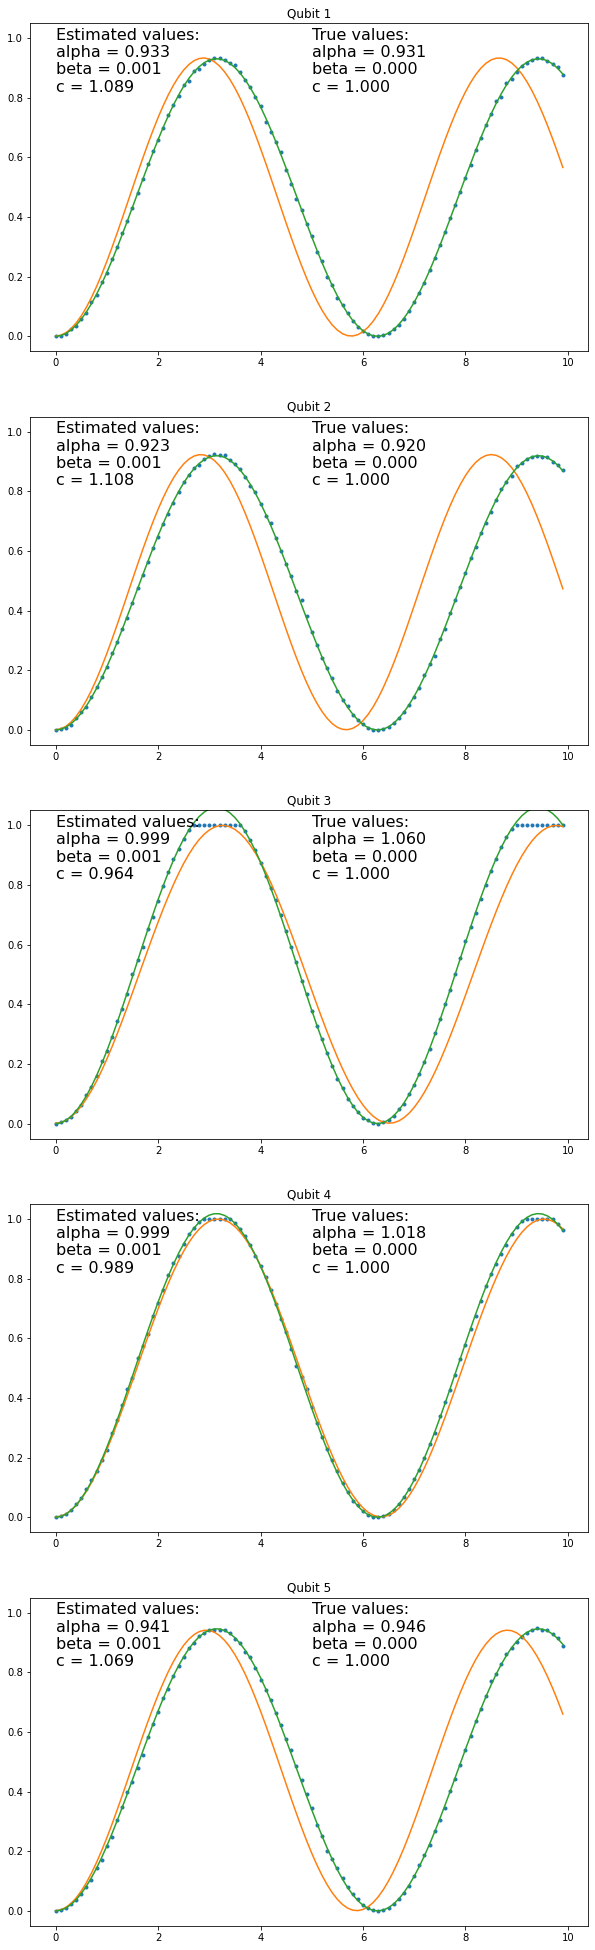

In [11]:
pi_alpha, *plot_coeffs = run_simulation(5, alpha_range=[0.9, 1.1], return_coeffs=True)
pi_alpha_500 = run_simulation(500, alpha_range=[0.9, 1.1], verbose=False)

print(f"Ideal estimate: {pi_init}")
print(f"Changing alpha: {pi_alpha}, {pi_alpha_500}")

plot_qubits(plot_coeffs)